**IMPORT LIBRARIES**

In [30]:
# Main data processing and visualization libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Scikit-learn modules for model selection, preprocessing, and evaluation metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)

# Scikit-learn classifiers and ensemble methods
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, VotingClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

# XGBoost for gradient boosting models
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

# TensorFlow/Keras for building deep neural network models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# IPython widgets for interactive controls in notebooks
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display, clear_output

# Tabulate for printing DataFrames and other tables in a readable format
from tabulate import tabulate

# Install and import pyexcel for reading Excel files directly into memory
# !pip install pyexcel pyexcel-xls
import io
from pyexcel_xls import get_data
import requests

# Functions for SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN


In [2]:
warnings.filterwarnings('ignore')

**LOADING AND PREPARING DATASETS FROM GITHUB**


In [3]:
# 1) Download the .xls file directly from the GitHub repository
url = "https://raw.githubusercontent.com/aporrini/Financial-Product-Recommender/main/Dataset2_Needs.xls"
xls_bytes = requests.get(url).content

# 2) Load the content into memory using pyexcel-xls
workbook = get_data(io.BytesIO(xls_bytes))

# 3) Extract the “Needs” and “Products” sheets and convert them to pandas DataFrames
needs_df = pd.DataFrame(workbook['Needs'][1:],    columns=workbook['Needs'][0])
products_df = pd.DataFrame(workbook['Products'][1:], columns=workbook['Products'][0])

# 4) Prepare the “Metadata” sheet: find the first row with at least 2 populated cells
meta_rows = workbook['Metadata']
header_idx = next(i for i, row in enumerate(meta_rows) if len(row) > 1)
meta_header = meta_rows[header_idx]
meta_data   = meta_rows[header_idx+1:]

# Create the DataFrame and explicitly rename the first two columns
metadata_df = pd.DataFrame(meta_data, columns=meta_header)
# Ensure these two columns have consistent names regardless of the original
metadata_df = metadata_df.rename(
    columns={
        metadata_df.columns[0]: 'Metadata',
        metadata_df.columns[1]: 'Unnamed: 1'
    }
)

# 5) Cleanup (e.g., remove the 'ID' column from needs_df if present)
if 'ID' in needs_df.columns:
    needs_df = needs_df.drop(columns='ID')

# 6) Quick sanity check: print the shapes of each DataFrame
print(needs_df.shape, products_df.shape, metadata_df.shape)


(5000, 9) (11, 3) (27, 2)


**EXPLORATIVE ANALYSIS**


In [4]:
def create_variable_summary(df, metadata_df):
    # Create empty lists to store the chosen statistics
    stats_dict = {
        'Variable': [],
        'Description': [],
        'Mean': [],
        'Std': [],
        'Missing': [],
        'Min': [],
        'Max': []
    }
   # Build a lookup from variable name to its description using the metadata DataFrame
    meta_dict = dict(zip(metadata_df['Metadata'], metadata_df['Unnamed: 1']))

    # Iterate over each column in the provided DataFrame
    for col in df.columns:
        # Record the variable name
        stats_dict['Variable'].append(col)
        # Lookup and record the description, or 'N/A' if not found
        stats_dict['Description'].append(meta_dict.get(col, 'N/A'))

        # If the column is numeric, compute basic statistics
        if pd.api.types.is_numeric_dtype(df[col]):
            stats_dict['Mean'].append(f"{df[col].mean():.2f}")
            stats_dict['Std'].append(f"{df[col].std():.2f}")
            stats_dict['Min'].append(f"{df[col].min():.2f}")
            stats_dict['Max'].append(f"{df[col].max():.2f}")
        else:
           # For non-numeric columns, mark statistics as not applicable
            stats_dict['Mean'].append('N/A')
            stats_dict['Std'].append('N/A')
            stats_dict['Min'].append('N/A')
            stats_dict['Max'].append('N/A')

        # Count and record the number of missing values in the column
        stats_dict['Missing'].append(df[col].isna().sum())

   # Convert the collected statistics into a pandas DataFrame
    return pd.DataFrame(stats_dict)


# Generate and display the summary table for the 'needs' dataset
print("NEEDS VARIABLES SUMMARY:")
needs_summary = create_variable_summary(needs_df, metadata_df)
display(needs_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))


# Generate and display the summary table for the 'products' dataset
print("\nPRODUCTS VARIABLES SUMMARY:")
products_summary = create_variable_summary(products_df, metadata_df)
display(products_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))


NEEDS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
Age,"Age, in years",55.25,11.97,0,18.00,97.00
Gender,"Gender (Female = 1, Male = 0)",0.49,0.50,0,0.00,1.00
FamilyMembers,Number of components,2.51,0.76,0,1.00,5.00
FinancialEducation,Normalized level of Financial Education (estimate),0.42,0.15,0,0.04,0.90
RiskPropensity,Normalized Risk propensity from MIFID profile,0.36,0.15,0,0.02,0.88
Income,Income (thousands of euros); estimate,62.99,44.36,0,1.54,365.32
Wealth,Wealth (thousands of euros); sum of investments and cash accounts,93.81,105.47,0,1.06,2233.23
IncomeInvestment,Boolean variable for Income investment; 1 = High propensity,0.38,0.49,0,0.00,1.00
AccumulationInvestment,Boolean variable for Accumulation/growth investment; 1 = High propensity,0.51,0.50,0,0.00,1.00



PRODUCTS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
IDProduct,Product description,6.00,3.32,0,1.00,11.00
Type,"1 = Accumulation product, 0 = Income product",0.64,0.50,0,0.00,1.00
Risk,Normalized Synthetic Risk Indicator,0.43,0.24,0,0.12,0.88


**FEATURE ENGINEERING AND SCALING FUNCTION**

In [5]:
def prepare_features(df):
    # Copy the input DataFrame to avoid side‐effects
    X = df.copy()

    # Log transform Wealth and Income to reduce skewness
    X['Wealth_log']       = np.log1p(X['Wealth'])
    X['Income_log']       = np.log1p(X['Income '])

    # Create the ratio of Income to Wealth, handling zero‐wealth cases
    X['Income_Wealth_Ratio'] = X['Income '] / X['Wealth'].replace(0, np.nan)
    # Log transform the ratio, filling any NaNs with the max income
    X['Income_Wealth_Ratio_log'] = np.log1p(
        X['Income_Wealth_Ratio'].fillna(X['Income '].max())
    )

    # Binary feature: single‐person household
    X['Is_Single']       = (X['FamilyMembers'] == 1).astype(int)
    # Binary feature: senior customers (Age > 65)
    X['Is_Senior']       = (X['Age'] > 65).astype(int)
    # Binary feature: whether any financial education exists
    X['Has_Education']   = (X['FinancialEducation'] > 0).astype(int)
    # Interaction term between risk propensity and age
    X['Risk_Age_Interaction'] = X['RiskPropensity'] * X['Age']

    # Define lists of base and engineered features
    features_base = [
        'Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
        'RiskPropensity', 'Wealth_log', 'Income_log'
    ]
    features_engineered = features_base + [
        'Income_Wealth_Ratio_log', 'Is_Single', 'Is_Senior',
        'Has_Education', 'Risk_Age_Interaction'
    ]

    # Scale both feature sets to [0,1] using MinMaxScaler
    scaler = MinMaxScaler()
    X_base       = pd.DataFrame(scaler.fit_transform(X[features_base]), columns=features_base)
    X_engineered = pd.DataFrame(scaler.fit_transform(X[features_engineered]), columns=features_engineered)

    # Return the scaled base features and the full engineered feature set
    return X_base, X_engineered

**DATA SPLITTING, CROSS-VALIDATION TRAINING AND RESULTS PRESENTATION FUNCTIONS**

Implementing stratified train/test splits, k-fold validation, and clear tabular metric reporting

In [6]:
# Step 1: Data split function
def split_data(X, y, test_size=0.2, random_state=42):

    # Splits features X and target y into train and test sets,preserving class distribution with stratification

    X_train, X_test, y_train, y_test = train_test_split(
        X,                       # feature matrix
        y,                       # target vector
        test_size=test_size,     # proportion of data to hold out for testing
        random_state=random_state,  # seed for reproducibility
        stratify=y               # maintain class balance
    )
    return X_train, X_test, y_train, y_test


# Step 2: Model training and evaluation function
def train_evaluate_model(X_train, y_train, X_test, y_test, model, k_folds=5):

  # Performs k-fold cross-validation on training data, collects metrics, then fits the model on full training set and evaluates on test set

  # Initialize k-fold splitter with shuffling
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    # Storage for cross-validation metrics
    cv_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    # Cross validation loop
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):

        # Split into current fold's train and validation sets
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model and predict on validation fold
        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)

        # Compute and store metrics for this fold
        cv_metrics['accuracy'].append(accuracy_score(y_val_fold, y_val_pred))
        cv_metrics['precision'].append(precision_score(y_val_fold, y_val_pred))
        cv_metrics['recall'].append(recall_score(y_val_fold, y_val_pred))
        cv_metrics['f1'].append(f1_score(y_val_fold, y_val_pred))

   # Retrain on full training set and evaluate on the held-out test set
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    return {
        'cv_metrics': {
            metric: {
                'mean': np.mean(scores),
                'std': np.std(scores)
            } for metric, scores in cv_metrics.items()
        },
        'test_metrics': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred)
        }
    }

# Step 3: Display results function
def display_results_table(results_dict, model_name, feature_type):

    # Formats and prints cross-validation and test metrics in a table

    # Prepare data for presentation
    cv_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
        'CV Mean': [
            results_dict['cv_metrics']['accuracy']['mean'],
            results_dict['cv_metrics']['precision']['mean'],
            results_dict['cv_metrics']['recall']['mean'],
            results_dict['cv_metrics']['f1']['mean']
        ],
        'CV Std': [
            results_dict['cv_metrics']['accuracy']['std'],
            results_dict['cv_metrics']['precision']['std'],
            results_dict['cv_metrics']['recall']['std'],
            results_dict['cv_metrics']['f1']['std']
        ],
        'Test Set': [
            results_dict['test_metrics']['accuracy'],
            results_dict['test_metrics']['precision'],
            results_dict['test_metrics']['recall'],
            results_dict['test_metrics']['f1']
        ]
    }

    # Create DataFrame and round for readability
    df = pd.DataFrame(cv_data)
    df = df.round(3)

# Print header and table
    print(f"\n{model_name} - {feature_type}")
    print("=" * 60)
    print(tabulate(df, headers='keys', tablefmt='pretty'))

**BENCHMARKING SIMPLE CLASSIFIERS TO EVALUATE ENGINEERED VS BASE FEATURES**

Comparative Performance Analysis of SVM, Naive Bayes, and Decision Tree Models

In [7]:
# Prepare feature matrices and target vectors
X_base, X_engineered = prepare_features(needs_df)
y_income = needs_df['IncomeInvestment']
y_accum = needs_df['AccumulationInvestment']

# Define the set of classifiers to benchmark
models = {
    'SVM': SVC(),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

# Loop over each target variable and each feature set
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)

    # Split base features into stratified train/test sets
    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)

    # Split engineered features into stratified train/test sets
    X_eng_train, X_eng_test, _, _ = split_data(X_engineered, y)

    # Evaluate each model on both feature sets
    for model_name, model in models.items():

        # Base Features
        results_base = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, model)
        display_results_table(results_base, model_name, "Base Features")

        # Engineered Features
        results_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, model)
        display_results_table(results_eng, model_name, "Engineered Features")


Target Variable: Income Investment

SVM - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.771  | 0.015  |  0.747   |
| 1 | Precision |  0.816  | 0.011  |  0.796   |
| 2 |  Recall   |  0.521  |  0.04  |  0.458   |
| 3 |    F1     |  0.635  | 0.027  |  0.582   |
+---+-----------+---------+--------+----------+

SVM - Engineered Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.742  | 0.013  |  0.724   |
| 1 | Precision |  0.826  | 0.011  |  0.781   |
| 2 |  Recall   |  0.416  | 0.029  |  0.391   |
| 3 |    F1     |  0.553  | 0.025  |  0.521   |
+---+-----------+---------+--------+----------+

NaiveBayes - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+-------

**BENCHMARKING ADVANCED MODELS ON ENGINEERED VS BASE FEATURES**

Comparative Performance Analysis of Random Forest and XGBoost Models

In [8]:
# Prepare features: generate both base and engineered feature sets for modeling
X_base, X_engineered = prepare_features(needs_df)
# Define binary target variables for income- and accumulation-oriented investments
y_income = needs_df['IncomeInvestment']
y_accum = needs_df['AccumulationInvestment']

# Define models: Initialize classifiers to benchmark against the prepared features
models = {
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    'RandomForest': RandomForestClassifier(random_state=42)
}

# Execute full analysis

# Loop through each investment target and each feature set to train, evaluate, and display results
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\n📈 Target Variable: {target_name}")
    print("=" * 90)

    # Create stratified train/test splits for both feature sets
    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    X_eng_train, X_eng_test, _, _ = split_data(X_engineered, y)

    # Evaluate each model on base and engineered features
    for model_name, model in models.items():

        # Base features evaluationse
        results_base = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, model)
        display_results_table(results_base, model_name, "Base Features")

        # Engineered features evaluation
        results_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, model)
        display_results_table(results_eng, model_name, "Engineered Features")



📈 Target Variable: Income Investment

XGBoost - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.792  | 0.015  |  0.763   |
| 1 | Precision |  0.789  | 0.013  |  0.765   |
| 2 |  Recall   |  0.625  | 0.028  |  0.552   |
| 3 |    F1     |  0.697  | 0.021  |  0.641   |
+---+-----------+---------+--------+----------+

XGBoost - Engineered Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |   0.8   | 0.016  |  0.769   |
| 1 | Precision |  0.809  | 0.016  |  0.782   |
| 2 |  Recall   |  0.627  | 0.031  |  0.552   |
| 3 |    F1     |  0.706  | 0.025  |  0.647   |
+---+-----------+---------+--------+----------+

RandomForest - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-------

It’s clear that the engineered feature set consistently outperforms the baseline across both simple and advanced classifiers.

From this point on, we’ll adopt the **engineered features** as our standard input for all subsequent modeling.


**MULTI-OUTPUT CLASSIFICATION ANALYSIS**

Combining Labels and Visualizing the Distribution of Multi-Output Investment Combinations


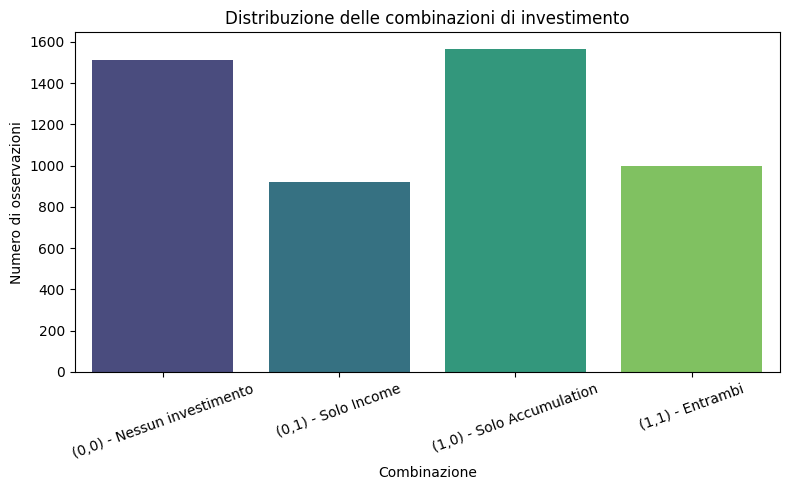

                         Label  Count
0  (0,0) - Nessun investimento   1514
1          (0,1) - Solo Income    920
2    (1,0) - Solo Accumulation   1568
3             (1,1) - Entrambi    998


In [9]:
# Create a new column 'Combo' by concatenating AccumulationInvestment and IncomeInvestment as strings
needs_df['Combo'] = needs_df['AccumulationInvestment'].astype(str) + ',' + needs_df['IncomeInvestment'].astype(str)

# Count the occurrences of each combination and convert to DataFrame
combo_counts = needs_df['Combo'].value_counts().sort_index()
combo_df = combo_counts.rename_axis('Combination').reset_index(name='Count')

# Map each combination code to a descriptive label
label_map = {
    '0,0': '(0,0) - Nessun investimento',
    '0,1': '(0,1) - Solo Income',
    '1,0': '(1,0) - Solo Accumulation',
    '1,1': '(1,1) - Entrambi'
}
combo_df['Label'] = combo_df['Combination'].map(label_map)


# Plot the distribution of investment combination labels
plt.figure(figsize=(8,5))
sns.barplot(data=combo_df, x='Label', y='Count', palette='viridis')
plt.title('Distribuzione delle combinazioni di investimento')
plt.xlabel('Combinazione')
plt.ylabel('Numero di osservazioni')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Print the counts table for reference
print(combo_df[['Label', 'Count']])


**MULTI-OUTPUT NEURAL NETWORK FOR INVESTMENT COMBINATION PREDICTION**

Encoding Dual Targets and Training a Deep Classifier with Early Stopping

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3132 - loss: 1.7669 - val_accuracy: 0.3925 - val_loss: 1.3456
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4064 - loss: 1.3666 - val_accuracy: 0.4212 - val_loss: 1.3043
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4555 - loss: 1.2637 - val_accuracy: 0.4300 - val_loss: 1.2619
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4677 - loss: 1.2451 - val_accuracy: 0.4588 - val_loss: 1.2208
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4646 - loss: 1.2320 - val_accuracy: 0.5075 - val_loss: 1.1669
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4957 - loss: 1.1844 - val_accuracy: 0.4938 - val_loss: 1.1454
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5267 - loss: 1.1545 - val_accuracy: 0.5213 - val_loss: 1.1131
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5454 - loss: 1.1163 - val_accuracy: 0.

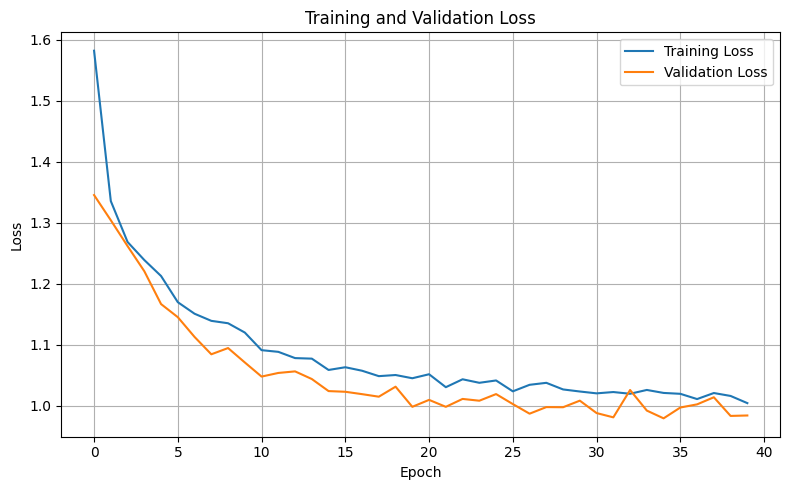

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


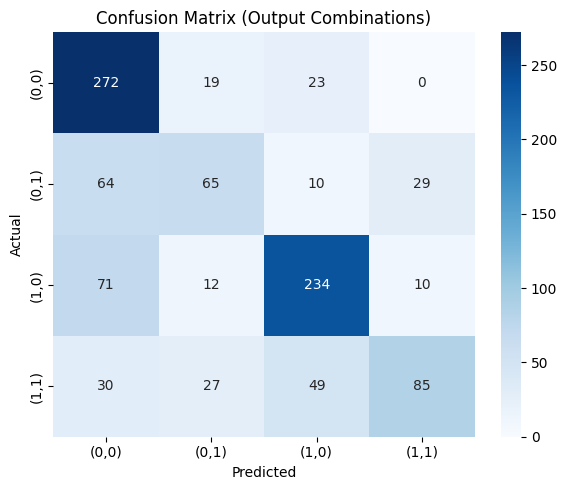

              precision    recall  f1-score   support

       (0,0)       0.62      0.87      0.72       314
       (0,1)       0.53      0.39      0.45       168
       (1,0)       0.74      0.72      0.73       327
       (1,1)       0.69      0.45      0.54       191

    accuracy                           0.66      1000
   macro avg       0.64      0.60      0.61      1000
weighted avg       0.66      0.66      0.64      1000



In [10]:
# Encode target from two binary columns into single categorical label 0–3 ---
def encode_target(y_df):
     # Map (AccumulationInvestment, IncomeInvestment) to a unique integer
    return y_df['AccumulationInvestment'] * 2 + y_df['IncomeInvestment']

# Prepare features and encoded labels
X_base, X_engineered = prepare_features(needs_df)
y_encoded = encode_target(needs_df[['AccumulationInvestment', 'IncomeInvestment']])
y_cat = to_categorical(y_encoded, num_classes=4)

# Split data into  Train (64%), Validation (16%) and Test (20%) sets
X_temp, X_test, y_temp, y_test = train_test_split(X_engineered, y_cat, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=1)

# Define the Sequential neural network architecture
model = Sequential([
    Input(shape=(X_engineered.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(4, activation='softmax')
])

# Compile model with optimizer, loss, and metric
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Configure early stopping to restore best weights
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Train the model and record history
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

# Plot training vs. validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Generate predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Define labels for confusion matrix
labels = ['(0,0)', '(0,1)', '(1,0)', '(1,1)']

#  Plot confusion matrix for multi-output classes
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Output Combinations)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Print detailed classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=labels))


In [11]:
## Calculate the Pearson correlation coefficient between the two binary targets
corr = needs_df['AccumulationInvestment'].corr(needs_df['IncomeInvestment'])
# Print the resulting correlation rounded to three decimal places
print(f"Correlazione tra Accumulation e Income: {corr:.3f}")


Correlazione tra Accumulation e Income: 0.011


As we can observe, the multi-output classifier struggles whenever the second bit (Income flag) is set to 1, leading to frequent misclassification of those cases. This performance issue reflects the extremely low correlation (~0.01) between the two targets, underlining their near-independence.

**STACKING CLASSIFIER FOR INCOME AND ACCUMULATION INVESTMENTS**

Building, Threshold Tuning, and Evaluation of Stacked Models with Recall Constraints





🏦 StackingClassifier - IncomeInvestment (recall ≥ 0.70)
✓ Best threshold with recall ≥ 0.70: 0.213 → F1 = 0.603

📄 Classification Report - IncomeInvestment
              precision    recall  f1-score   support

           0      0.768     0.596     0.671       616
           1      0.523     0.711     0.603       384

    accuracy                          0.640      1000
   macro avg      0.645     0.653     0.637      1000
weighted avg      0.674     0.640     0.645      1000



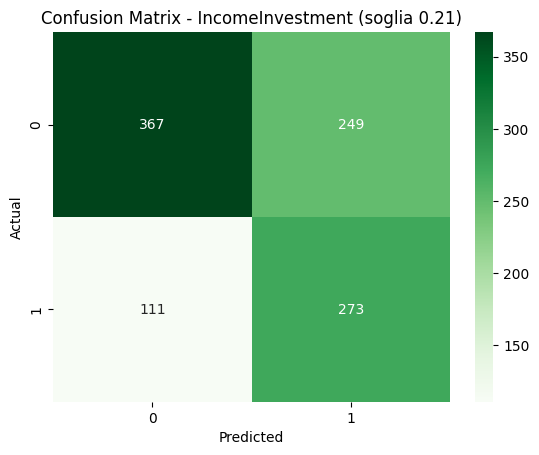


💰 StackingClassifier - AccumulationInvestment (recall ≥ 0.82)
✓ Best threshold with recall ≥ 0.82: 0.321 → F1 = 0.793

✓ Selected threshold = 0.321, F1 = 0.793

📄 Classification Report - AccumulationInvestment
              precision    recall  f1-score   support

           0      0.798     0.731     0.763       487
           1      0.764     0.825     0.793       513

    accuracy                          0.779      1000
   macro avg      0.781     0.778     0.778      1000
weighted avg      0.780     0.779     0.778      1000



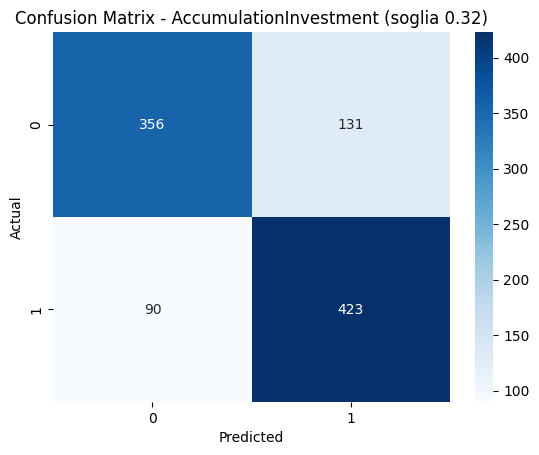

In [12]:
# Compute imbalance ratio for positive class weighting scale_pos_weight
def get_scale_pos_weight(y):
    return (y == 0).sum() / (y == 1).sum()

# Function to find the optimal threshold maximizing F1 score
def find_best_threshold(y_true, probs, verbose=True):
    best_f1 = 0
    best_thresh = 0.5
    for t in np.linspace(0.05, 0.95, 100):
        preds = (probs >= t).astype(int)
        f1 = f1_score(y_true, preds, pos_label=1)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    if verbose:
        print(f"✓ Best threshold = {best_thresh:.3f}, F1 = {best_f1:.3f}")
    return best_thresh, best_f1

# Prepare data for modeling
X_base , X_engineered = prepare_features(needs_df)
X = X_engineered
y_income = needs_df['IncomeInvestment']
y_accum  = needs_df['AccumulationInvestment']

# Split into train/test sets for each target
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y_income, test_size=0.2, random_state=42, stratify=y_income)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y_accum, test_size=0.2, random_state=42, stratify=y_accum)

# Base learners and meta-learner for stacking
def make_stack_model(y_train):
    rf  = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train), random_state=42)
    svm = SVC(probability=True, class_weight='balanced', random_state=42)
    base_learners = [('rf', rf), ('xgb', xgb), ('svm', svm)]
    meta = LogisticRegression(max_iter=1000)
    return StackingClassifier(estimators=base_learners, final_estimator=meta, cv=5)

# Threshold optimization with recall constraint for IncomeInvestment: recall >= 0.7, maximize F1
def find_threshold_recall_constrained(y_true, probs, min_recall=0.7, verbose=True):
    best_f1 = 0
    best_thresh = None
    for t in np.linspace(0.05, 0.95, 200):
        preds = (probs >= t).astype(int)
        rec = recall_score(y_true, preds, pos_label=1)
        if rec >= min_recall:
            f1 = f1_score(y_true, preds, pos_label=1)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = t
    if verbose:
        if best_thresh is not None:
            print(f"✓ Best threshold with recall ≥ {min_recall:.2f}: {best_thresh:.3f} → F1 = {best_f1:.3f}")
        else:
            print("⚠️ Nessuna soglia soddisfa il vincolo di recall.")
    return best_thresh, best_f1

# Stacking classifier for IncomeInvestment with a recall constraint
from sklearn.metrics import recall_score

print("\n🏦 StackingClassifier - IncomeInvestment (recall ≥ 0.70)")

stack_income = make_stack_model(y_train_i)
stack_income.fit(X_train_i, y_train_i)
probs_i = stack_income.predict_proba(X_test_i)[:, 1]
best_t_i, best_f1_i = find_threshold_recall_constrained(y_test_i, probs_i, min_recall=0.7)

if best_t_i is not None:
    preds_i = (probs_i >= best_t_i).astype(int)

    print("\n📄 Classification Report - IncomeInvestment")
    print(classification_report(y_test_i, preds_i, digits=3))
    sns.heatmap(confusion_matrix(y_test_i, preds_i), annot=True, fmt='d', cmap='Greens')
    plt.title(f"Confusion Matrix - IncomeInvestment (soglia {best_t_i:.2f})")
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()
else:
    print("⚠️ Nessuna soglia raggiunge recall ≥ 0.70")


# Stacking classifier for AccumulationInvestment with recall constraint: recall ≥ 0.83
print("\n💰 StackingClassifier - AccumulationInvestment (recall ≥ 0.82)")

stack_accum = make_stack_model(y_train_a)
stack_accum.fit(X_train_a, y_train_a)
probs_a = stack_accum.predict_proba(X_test_a)[:, 1]

# Find threshold with recall constraint ≥ 0.8
best_t_a, best_f1_a = find_threshold_recall_constrained(y_test_a, probs_a, min_recall=0.82)

if best_t_a is not None:
    preds_a = (probs_a >= best_t_a).astype(int)

    print(f"\n✓ Selected threshold = {best_t_a:.3f}, F1 = {best_f1_a:.3f}")
    print("\n📄 Classification Report - AccumulationInvestment")
    print(classification_report(y_test_a, preds_a, digits=3))
    cm = confusion_matrix(y_test_a, preds_a)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - AccumulationInvestment (soglia {best_t_a:.2f})")
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()
else:
    print("⚠️ Nessuna soglia soddisfa il vincolo di recall ≥ 0.82")



**SMOTE IMPROVEMENTS**

We add a special kind of SMOTE to try fix the imbalances in the dataset for the income investing. We do not apply the same logic for the accumulation because the dataset is quite balanced and empirically we have seen that we would get worse results


🏦 IncomeInvestment (recall ≥ 0.70)
✓ Threshold ≥ recall 0.70: 0.235 → F1 = 0.637
              precision    recall  f1-score   support

           0      0.789     0.679     0.729       616
           1      0.579     0.708     0.637       384

    accuracy                          0.690      1000
   macro avg      0.684     0.693     0.683      1000
weighted avg      0.708     0.690     0.694      1000



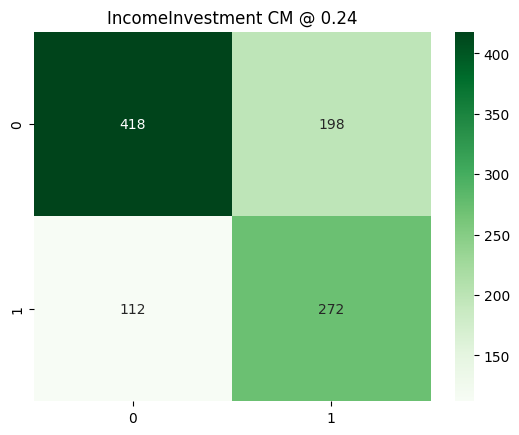


💰 AccumulationInvestment (recall ≥ 0.82)
✓ Threshold ≥ recall 0.82: 0.321 → F1 = 0.793
              precision    recall  f1-score   support

           0      0.798     0.731     0.763       487
           1      0.764     0.825     0.793       513

    accuracy                          0.779      1000
   macro avg      0.781     0.778     0.778      1000
weighted avg      0.780     0.779     0.778      1000



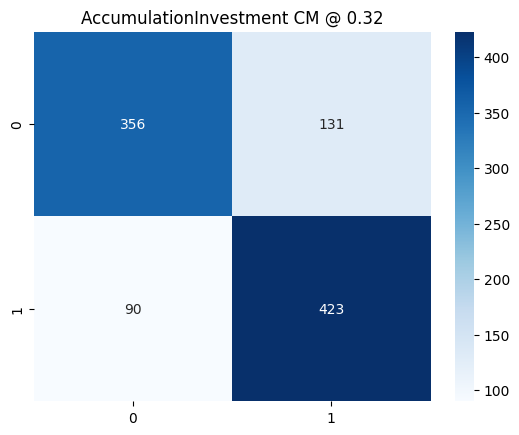

In [ ]:
# ———————————————————————————————
# 1) Prepare features and targets
# ———————————————————————————————
X_base, X_engineered = prepare_features(needs_df)
X = X_engineered
y_income = needs_df['IncomeInvestment']
y_accum  = needs_df['AccumulationInvestment']

# ———————————————————————————————
# 2) Split into train/test for each target
# ———————————————————————————————
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X, y_income, test_size=0.2, random_state=42, stratify=y_income
)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X, y_accum,  test_size=0.2, random_state=42, stratify=y_accum
)

# ———————————————————————————————
# 3) IncomeInvestment pipeline: Borderline-SMOTE + ENN
# ———————————————————————————————
sm_i = BorderlineSMOTE(kind='borderline-1', sampling_strategy='auto', random_state=42)
X_bi, y_bi = sm_i.fit_resample(X_train_i, y_train_i)
sm_enn_i = SMOTEENN(random_state=42)
X_train_i_res, y_train_i_res = sm_enn_i.fit_resample(X_bi, y_bi)

# ———————————————————————————————
# 4) AccumulationInvestment: no oversampling
# ———————————————————————————————
X_train_a_res, y_train_a_res = X_train_a, y_train_a

# ———————————————————————————————
# 5) Helper functions
# ———————————————————————————————
def get_scale_pos_weight(y):
    return (y == 0).sum() / (y == 1).sum()

def find_threshold_recall_constrained(y_true, probs, min_recall, verbose=True):
    best_f1, best_thresh = 0, None
    for t in np.linspace(0.05, 0.95, 200):
        preds = (probs >= t).astype(int)
        if recall_score(y_true, preds) >= min_recall:
            f1 = f1_score(y_true, preds)
            if f1 > best_f1:
                best_f1, best_thresh = f1, t
    if verbose:
        if best_thresh is not None:
            print(f"✓ Threshold ≥ recall {min_recall:.2f}: {best_thresh:.3f} → F1 = {best_f1:.3f}")
        else:
            print("⚠️ Nessuna soglia soddisfa il vincolo.")
    return best_thresh, best_f1

def make_stack_model_income(y_train):
    rf  = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train),
                        random_state=42)
    svm = SVC(probability=True, class_weight='balanced', random_state=42)
    learners = [('rf', rf), ('xgb', xgb), ('svm', svm)]
    meta = LogisticRegression(class_weight='balanced', max_iter=1000)
    return StackingClassifier(estimators=learners, final_estimator=meta, cv=5)

def make_stack_model_accum(y_train):
    rf  = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                        scale_pos_weight=get_scale_pos_weight(y_train),
                        random_state=42)
    svm = SVC(probability=True, class_weight='balanced', random_state=42)
    learners = [('rf', rf), ('xgb', xgb), ('svm', svm)]
    meta = LogisticRegression(max_iter=1000)  # no class_weight here
    return StackingClassifier(estimators=learners, final_estimator=meta, cv=5)

# ———————————————————————————————
# 6) Train & evaluate IncomeInvestment (recall ≥ 0.70)
# ———————————————————————————————
print("\n🏦 IncomeInvestment (recall ≥ 0.70)")
stack_inc = make_stack_model_income(y_train_i_res)
stack_inc.fit(X_train_i_res, y_train_i_res)
probs_i = stack_inc.predict_proba(X_test_i)[:, 1]
t_i, f1_i = find_threshold_recall_constrained(y_test_i, probs_i, min_recall=0.70)
if t_i is not None:
    preds_i = (probs_i >= t_i).astype(int)
    print(classification_report(y_test_i, preds_i, digits=3))
    sns.heatmap(confusion_matrix(y_test_i, preds_i), annot=True, fmt='d', cmap='Greens')
    plt.title(f"IncomeInvestment CM @ {t_i:.2f}")
    plt.show()

# ———————————————————————————————
# 7) Train & evaluate AccumulationInvestment (recall ≥ 0.82)
# ———————————————————————————————
print("\n💰 AccumulationInvestment (recall ≥ 0.82)")
stack_acc = make_stack_model_accum(y_train_a_res)
stack_acc.fit(X_train_a_res, y_train_a_res)
probs_a = stack_acc.predict_proba(X_test_a)[:, 1]
t_a, f1_a = find_threshold_recall_constrained(y_test_a, probs_a, min_recall=0.82)
if t_a is not None:
    preds_a = (probs_a >= t_a).astype(int)
    print(classification_report(y_test_a, preds_a, digits=3))
    sns.heatmap(confusion_matrix(y_test_a, preds_a), annot=True, fmt='d', cmap='Blues')
    plt.title(f"AccumulationInvestment CM @ {t_a:.2f}")
    plt.show()


**PERMUTATION IMPORTANCE ANALYSIS FOR INCOME INVESTMENT MODEL**

Measuring Feature Impact on F1-Score Drop in Stacked Classifier

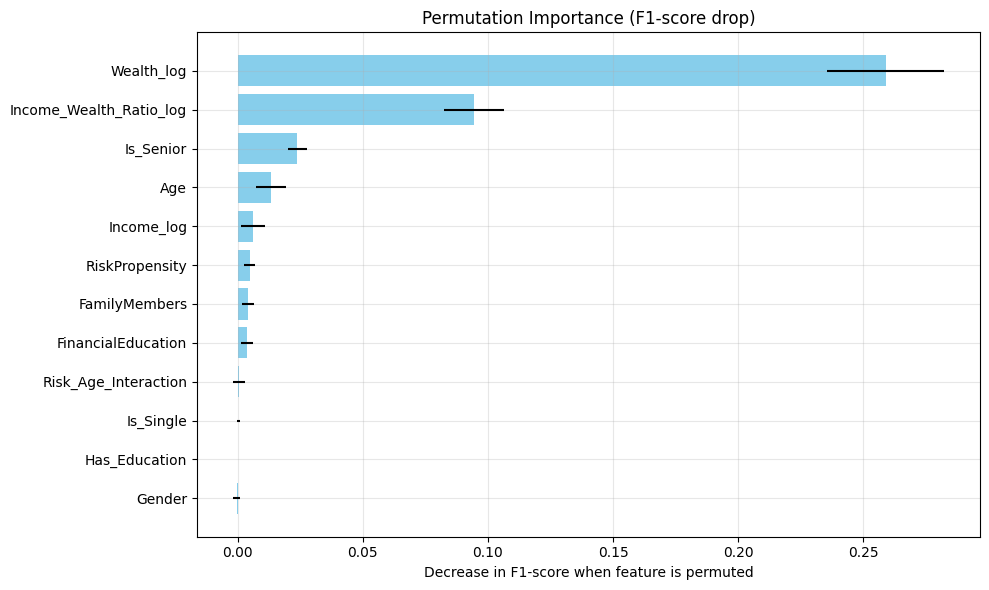

,Feature,Importance Mean,Importance Std
0,Wealth_log,0.258868,0.023490
1,Income_Wealth_Ratio_log,0.094431,0.011789
2,Is_Senior,0.023812,0.003753
3,Age,0.013196,0.005942
4,Income_log,0.006232,0.004838
5,RiskPropensity,0.004817,0.002166
6,FamilyMembers,0.004169,0.002549
7,FinancialEducation,0.003851,0.002396
8,Risk_Age_Interaction,0.000412,0.002439
9,Is_Single,0.000213,0.000640


In [13]:
# Choose the trained stacking model and evaluation set
model = stack_income
X_eval = X_test_i.copy()
y_eval = y_test_i.copy()

# Compute permutation importances using F1-score as the metric
result = permutation_importance(
    model,
    X_eval,
    y_eval,
    n_repeats=10,
    random_state=42,
    scoring='f1'
)

# Prepare importances DataFrame sorted by mean importance
importances = pd.DataFrame({
    'Feature': X_eval.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# Plot top features with error bars showing std deviation
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance Mean'], xerr=importances['Importance Std'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Permutation Importance (F1-score drop)")
plt.xlabel("Decrease in F1-score when feature is permuted")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Display the top 10 features in a table
importances.reset_index(drop=True).head(10)


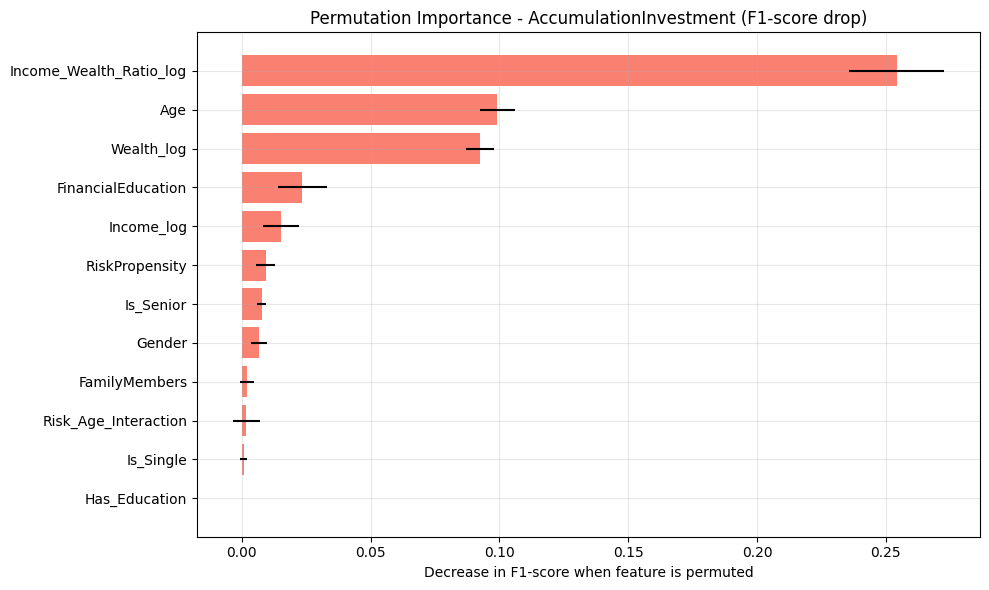

In [14]:
# Compute permutation-based feature importances for the AccumulationInvestment stacking model
model = stack_accum
X_eval = X_test_a.copy()
y_eval = y_test_a.copy()

# Calculate how much F1-score drops when each feature is randomly shuffled
result = permutation_importance(
    model,
    X_eval,
    y_eval,
    n_repeats=10,
    random_state=42,
    scoring='f1'
)

# Build a DataFrame of mean and standard deviation of importances, sorted by mean decrease
importances = pd.DataFrame({
    'Feature': X_eval.columns,
    'Importance Mean': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# Plot the top features showing their average F1-score drop and variability
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance Mean'], xerr=importances['Importance Std'], color='salmon')
plt.gca().invert_yaxis()
plt.title("Permutation Importance - AccumulationInvestment (F1-score drop)")
plt.xlabel("Decrease in F1-score when feature is permuted")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()




**CLIENT NEEDS-BASED PRODUCT RECOMENDATION PIPELINE**

Mapping Risk Propensity to Suitable Financial Products

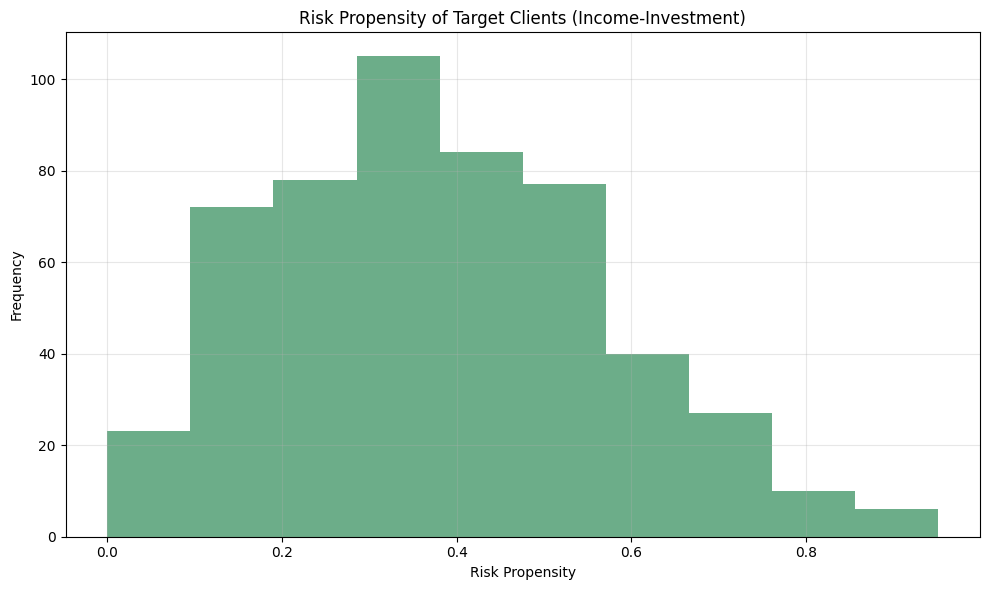


📊 Recommendation statistics (Income-Investment):
Total customers analyzed: 522
Customers with valid recommendations: 499 (95.59%)
Customers without suitable recommendations: 23


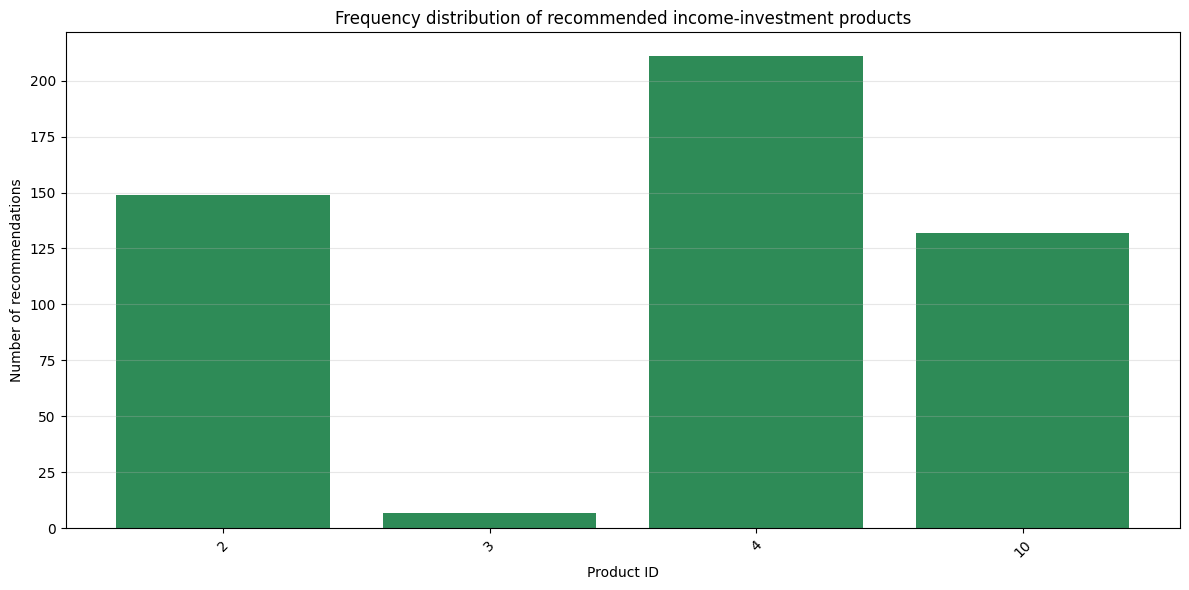


🏅 Top 3 recommended income-investment products:

🔹 Product ID: 4
Name: Balanced High Dividend Mutual Fund
Risk: 0.44
Recommended to 211 clients

🔹 Product ID: 2
Name: Income Conservative Unit-Linked (Life Insurance)
Risk: 0.3
Recommended to 149 clients

🔹 Product ID: 10
Name: Fixed Income Segregated Account
Risk: 0.13
Recommended to 132 clients


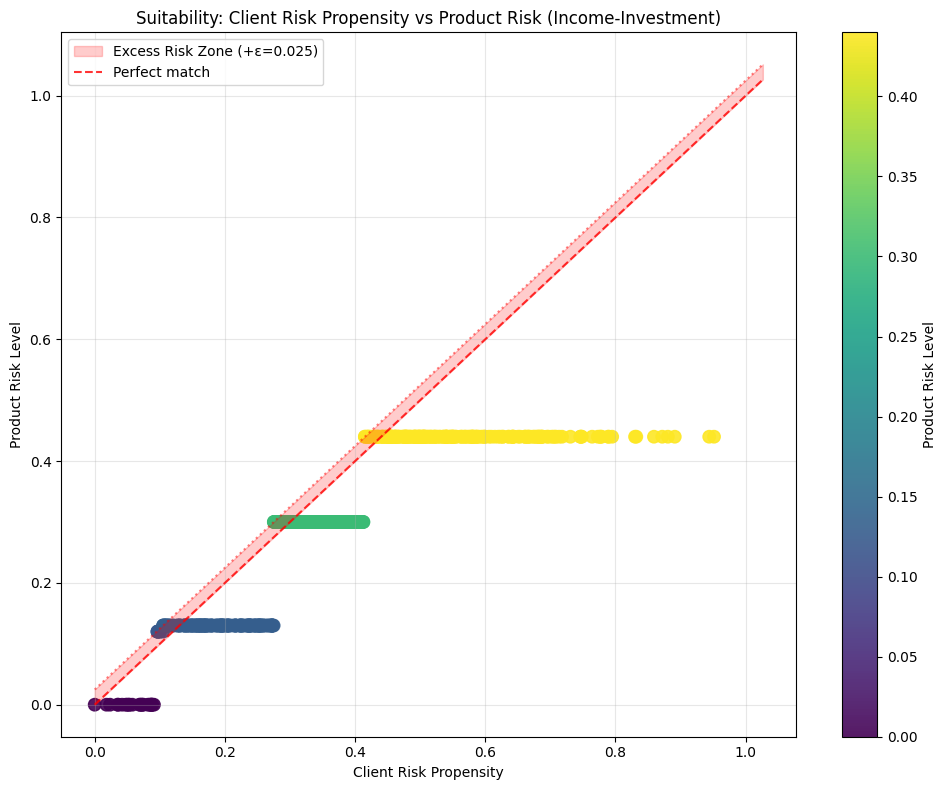

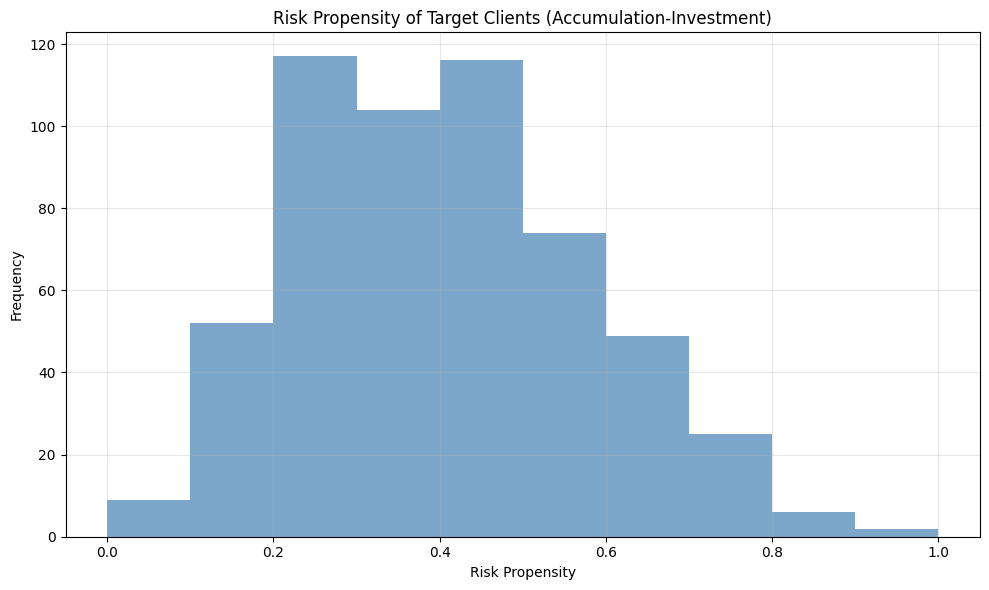


📊 Recommendation statistics (Accumulation-Investment):
Total customers analyzed: 554
Customers with valid recommendations: 443 (79.96%)
Customers without suitable recommendations: 111


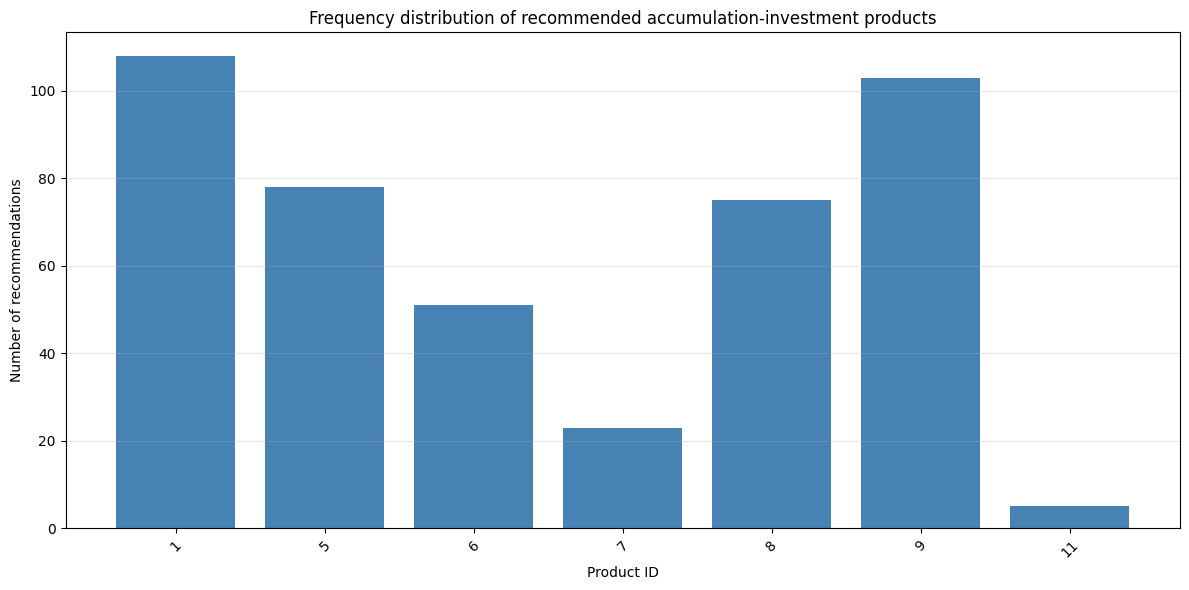


🏅 Top 3 recommended accumulation-investment products:

🔹 Product ID: 1
Name: Balanced Mutual Fund
Risk: 0.55
Recommended to 108 clients

🔹 Product ID: 9
Name: Cautious Allocation Segregated Account
Risk: 0.27
Recommended to 103 clients

🔹 Product ID: 5
Name: Balanced Mutual Fund
Risk: 0.41
Recommended to 78 clients


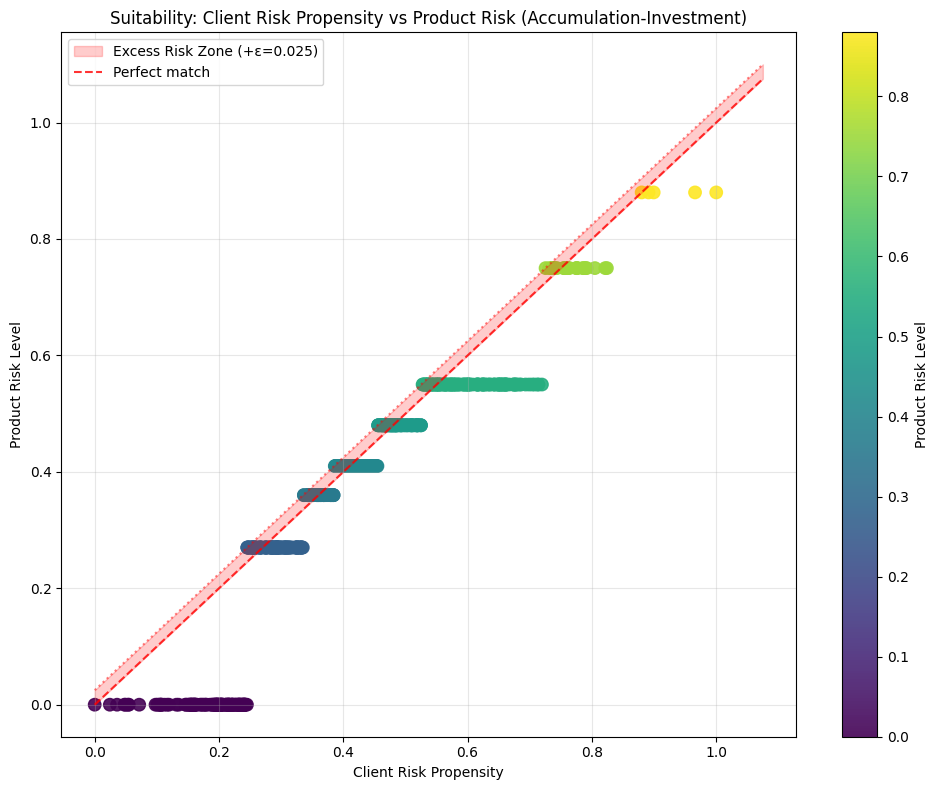

In [15]:
# Map product IDs to human-readable product names
product_name_map = {
    1: "Balanced Mutual Fund",
    2: "Income Conservative Unit-Linked (Life Insurance)",
    3: "Fixed Income Mutual Fund",
    4: "Balanced High Dividend Mutual Fund",
    5: "Balanced Mutual Fund",
    6: "Defensive Flexible Allocation Unit-Linked (Life Insurance)",
    7: "Aggressive Flexible Allocation Unit-Linked (Life Insurance)",
    8: "Balanced Flexible Allocation Unit-Linked (Life Insurance)",
    9: "Cautious Allocation Segregated Account",
    10: "Fixed Income Segregated Account",
    11: "Total Return Aggressive Allocation Segregated Account"
}
products_df['ProductName'] = products_df['IDProduct'].map(product_name_map)

# Function to build recommendation DataFrame using Naive Bayes approach
def build_nba_df(y_pred, X_test, product_type_label, epsilon=0.05):
    client_indices = np.where(y_pred == 1)[0]  # indices of clients predicted positive
    client_ids = needs_df.iloc[X_test.index[client_indices]].index.values
    client_risks = X_test.iloc[client_indices]['RiskPropensity'].values

    # Filter products by desired type (0=Income, 1=Accumulation)
    product_pool = products_df[products_df['Type'] == product_type_label].copy()
    nba_records = []

    for cid, crisk in zip(client_ids, client_risks):
        max_risk = crisk + epsilon
        # Select products within client's risk tolerance
        suitable = product_pool[product_pool['Risk'] <= max_risk]
        if not suitable.empty:

           # Recommend the highest-risk product that does not exceed tolerance
            best_product = suitable.loc[suitable['Risk'].idxmax()]
            nba_records.append({
                'ClientID': cid,
                'ClientRiskPropensity': crisk,
                'RecommendedProductID': best_product['IDProduct'],
                'ProductRiskLevel': best_product['Risk'],
                'ProductName': best_product['ProductName']
            })
        else:

           # No suitable product found
            nba_records.append({
                'ClientID': cid,
                'ClientRiskPropensity': crisk,
                'RecommendedProductID': 0,
                'ProductRiskLevel': 0,
                'ProductName': 'N/A'
            })

    return pd.DataFrame(nba_records)

# Function to analyze and plot recommendation outcomes
def plot_recommendation_analysis(nba_df, label, epsilon=0.05, color='#4682B4'):

    # Distribution of client risk propensities
    plt.figure(figsize=(10, 6))
    plt.hist(nba_df['ClientRiskPropensity'], bins=10, color=color, alpha=0.7)
    plt.title(f'Risk Propensity of Target Clients ({label})')
    plt.xlabel('Risk Propensity')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    total = len(nba_df)
    valid = (nba_df['RecommendedProductID'] > 0).sum()
    print(f"\n📊 Recommendation statistics ({label}):")
    print(f"Total customers analyzed: {total}")
    print(f"Customers with valid recommendations: {valid} ({100 * valid / total:.2f}%)")
    print(f"Customers without suitable recommendations: {total - valid}")

    if valid > 0:
        # Frequency distribution of recommended products
        plt.figure(figsize=(12, 6))
        counts = nba_df[nba_df['RecommendedProductID'] > 0]['RecommendedProductID'].value_counts().sort_index()
        plt.bar(counts.index.astype(str), counts.values, color=color)
        plt.title(f'Frequency distribution of recommended {label.lower()} products')
        plt.xlabel('Product ID')
        plt.ylabel('Number of recommendations')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Print top-3 recommended products
        top3 = counts.nlargest(3).index
        print(f"\n🏅 Top 3 recommended {label.lower()} products:")
        for pid in top3:
            row = products_df[products_df['IDProduct'] == pid].iloc[0]
            print(f"\n🔹 Product ID: {pid}")
            print(f"Name: {row['ProductName']}")
            print(f"Risk: {row['Risk']}")
            print(f"Recommended to {counts[pid]} clients")


    # Scatter plot of client vs product risk levels
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(nba_df['ClientRiskPropensity'], nba_df['ProductRiskLevel'],
                     c=nba_df['ProductRiskLevel'], cmap='viridis', s=80, alpha=0.9)
    max_val = max(nba_df['ClientRiskPropensity'].max(), nba_df['ProductRiskLevel'].max()) + epsilon + 0.05
    x_vals = np.linspace(0, max_val, 500)
    plt.fill_between(x_vals, x_vals, x_vals + epsilon, color='red', alpha=0.2, label=f'Excess Risk Zone (+ε={epsilon})')
    plt.plot(x_vals, x_vals, 'r--', label='Perfect match', alpha=0.8)
    plt.plot(x_vals, x_vals + epsilon, 'r:', alpha=0.5)
    plt.colorbar(sc, label='Product Risk Level')
    plt.title(f'Suitability: Client Risk Propensity vs Product Risk ({label})')
    plt.xlabel('Client Risk Propensity')
    plt.ylabel('Product Risk Level')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Build and visualize recommendations for Income and Accumulation
epsilon = 0.025
nba_income = build_nba_df(preds_i, X_test_i, product_type_label=0, epsilon=epsilon)
nba_accum  = build_nba_df(preds_a, X_test_a, product_type_label=1, epsilon=epsilon)

plot_recommendation_analysis(nba_income, 'Income-Investment', epsilon=epsilon, color='#2E8B57')
plot_recommendation_analysis(nba_accum,  'Accumulation-Investment', epsilon=epsilon, color='#4682B4')


**EXTENDING THE PRODUCT CATALOG**

Appending New Offerings and Filtering Out Invalid Risk Entries

In [16]:
# Brute-force addition of 5 new products with specified Type and Risk levels
new_products = pd.DataFrame({
    'IDProduct': [12, 13, 14, 15, 16],
    'Type':       [0,   0,  1,  1,  0],
    'Risk':       [0.55,0.70,0.70,0.15,0.85]
})
products_df = pd.concat([products_df, new_products], ignore_index=True)

# Remove any rows where Risk equals 0.12 (cleanup of unwanted entries)
products_df = products_df.loc[products_df['Risk'] != 0.12]


# Verify the updated DataFrame shape
print("Products:", products_df.shape)


Products: (15, 4)


**CLIENT NEEDS RECOMMENTATION PIPELINE**

Mapping Client Risk Propensities to Product Recommendations and Analyzing Outcomes

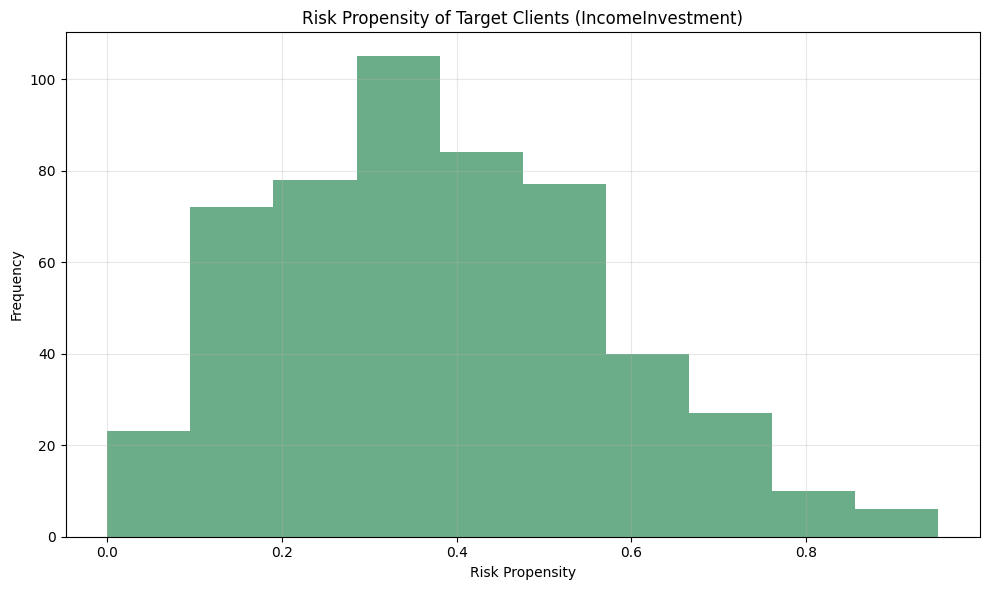


📊 Recommendation statistics (IncomeInvestment):
Total customers analyzed: 522
Customers with valid recommendations: 492 (94.25%)
Customers without suitable recommendations: 30


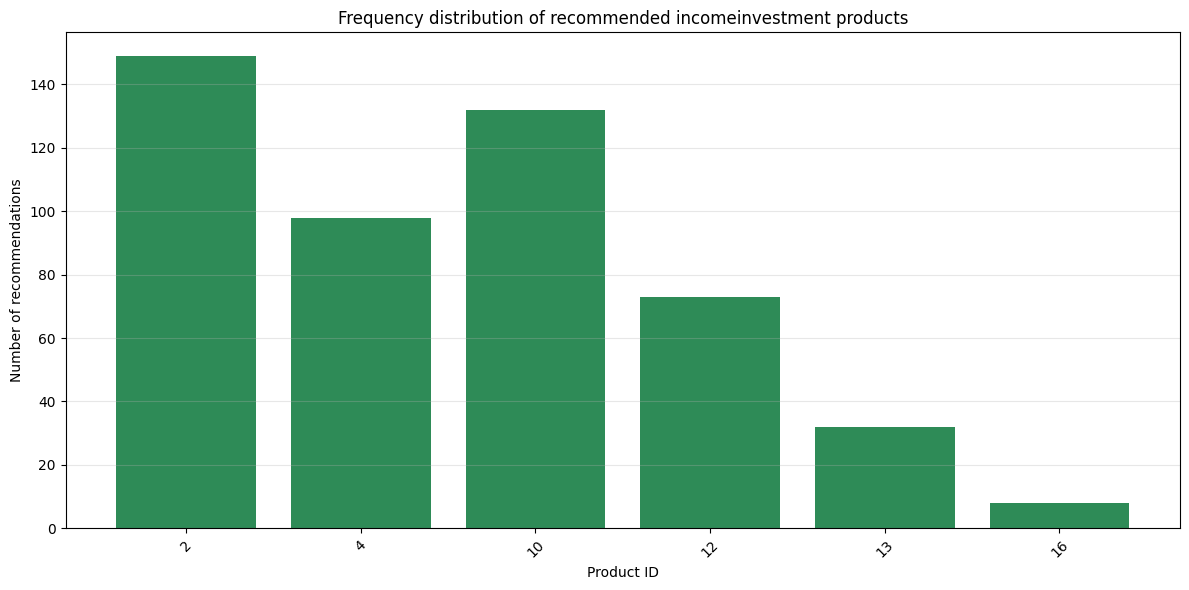


🏅 Top 3 recommended incomeinvestment products:

🔹 Product ID: 2
Name: Income Conservative Unit-Linked (Life Insurance)
Risk: 0.3
Recommended to 149 clients

🔹 Product ID: 10
Name: Fixed Income Segregated Account
Risk: 0.13
Recommended to 132 clients

🔹 Product ID: 4
Name: Balanced High Dividend Mutual Fund
Risk: 0.44
Recommended to 98 clients


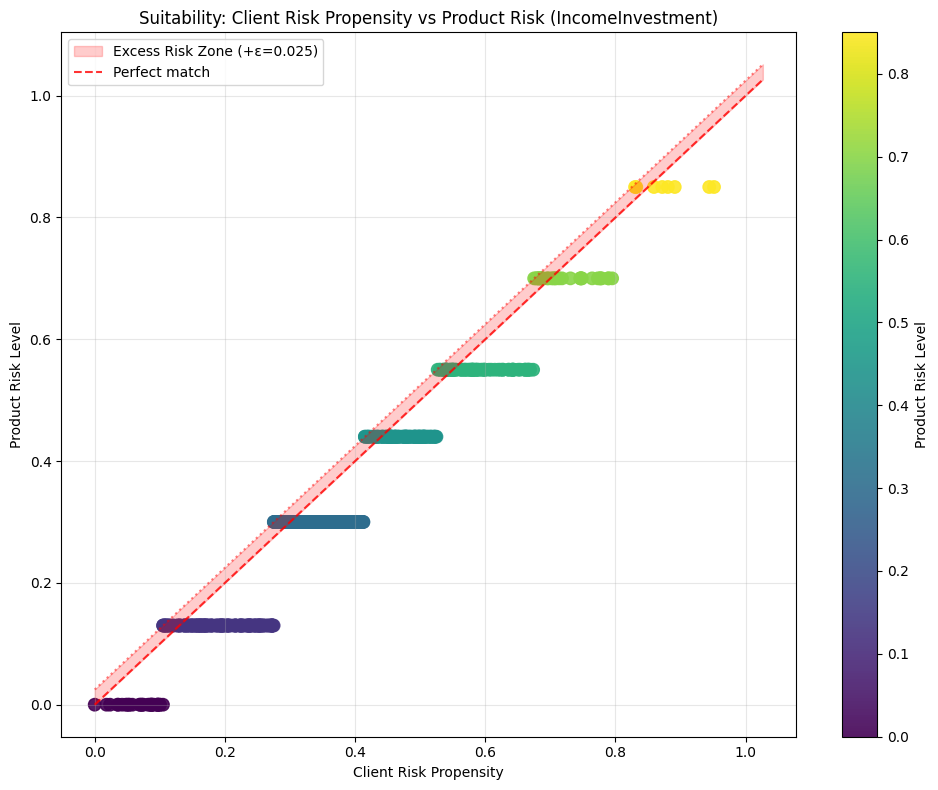

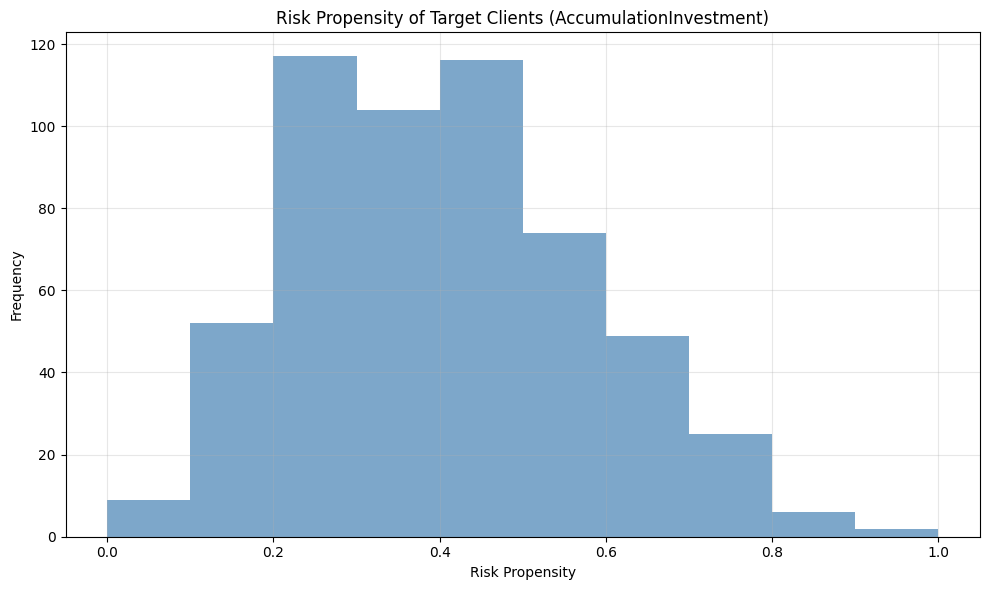


📊 Recommendation statistics (AccumulationInvestment):
Total customers analyzed: 554
Customers with valid recommendations: 536 (96.75%)
Customers without suitable recommendations: 18


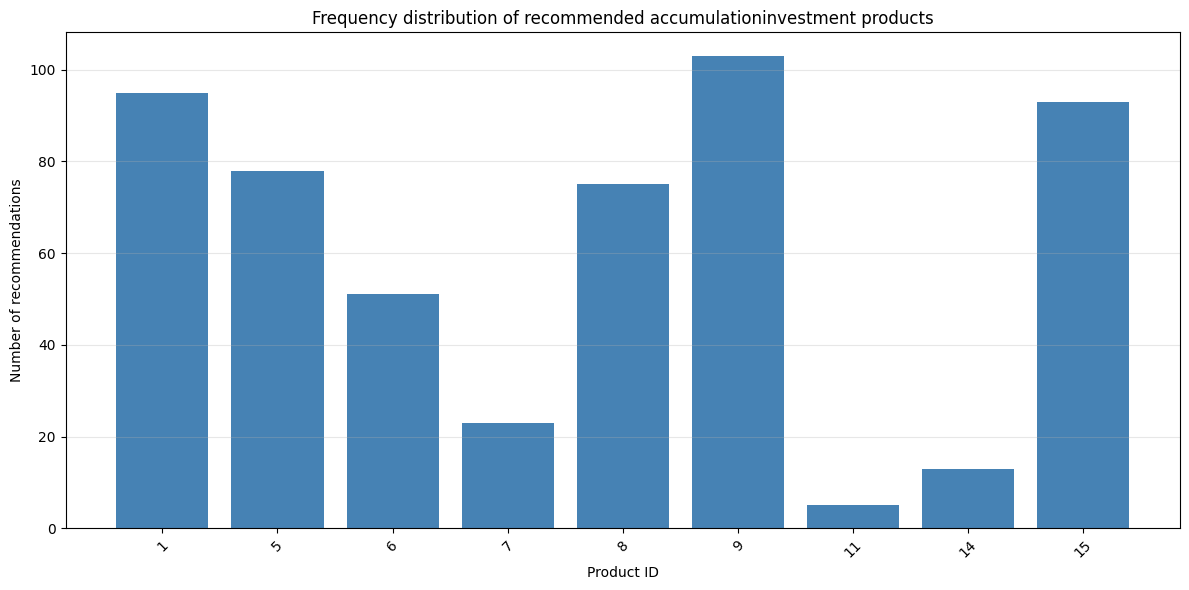


🏅 Top 3 recommended accumulationinvestment products:

🔹 Product ID: 9
Name: Cautious Allocation Segregated Account
Risk: 0.27
Recommended to 103 clients

🔹 Product ID: 1
Name: Balanced Mutual Fund
Risk: 0.55
Recommended to 95 clients

🔹 Product ID: 15
Name: Short-Term Government Bond Accumulation Fund
Risk: 0.15
Recommended to 93 clients


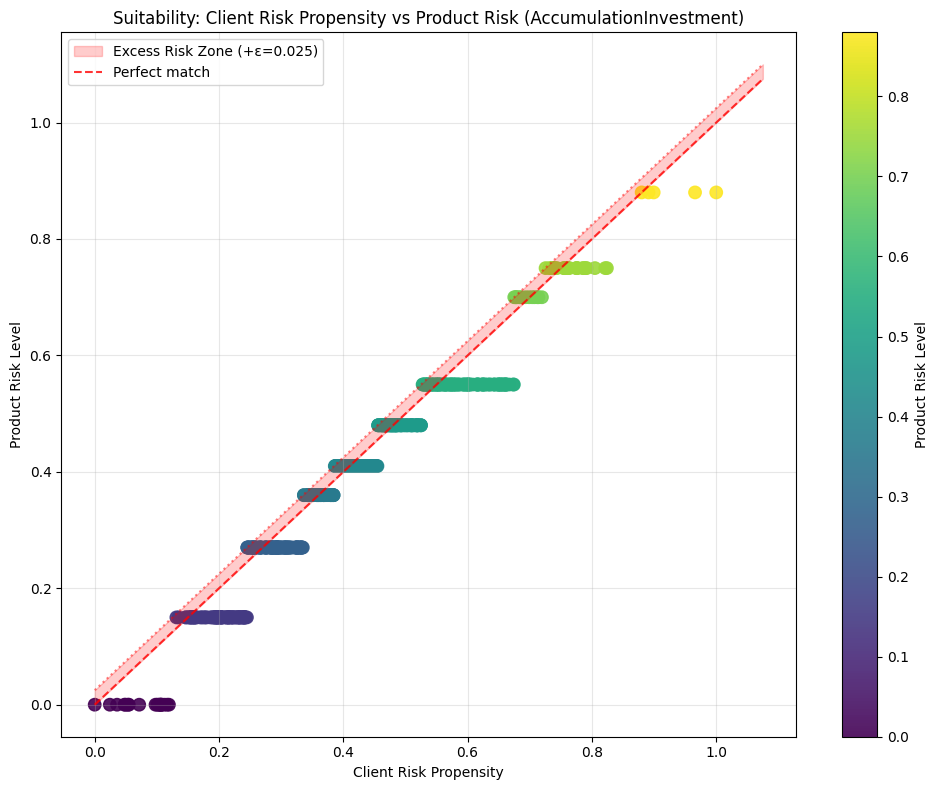

In [17]:
# Map product IDs to descriptive names
product_name_map = {
    1: "Balanced Mutual Fund",
    2: "Income Conservative Unit-Linked (Life Insurance)",
    3: "Fixed Income Mutual Fund",
    4: "Balanced High Dividend Mutual Fund",
    5: "Balanced Mutual Fund",
    6: "Defensive Flexible Allocation Unit-Linked (Life Insurance)",
    7: "Aggressive Flexible Allocation Unit-Linked (Life Insurance)",
    8: "Balanced Flexible Allocation Unit-Linked (Life Insurance)",
    9: "Cautious Allocation Segregated Account",
    10: "Fixed Income Segregated Account",
    11: "Total Return Aggressive Allocation Segregated Account",
    12:	"Global Diversified Income Fund",
    13:	"Emerging Markets High Yield Bond Fund",
    14:	"Sustainable Growth Equity Portfolio",
    15:	"Short-Term Government Bond Accumulation Fund",
    16:	"Tranche Equity CDO"
}
products_df['ProductName'] = products_df['IDProduct'].map(product_name_map)

# Function to build recommendation DataFrame based on predicted need and risk tolerance
def build_nba_df(y_pred, X_test, product_type_label, epsilon=0.05):

    # Identify indices of clients predicted positive for this investment typ
    client_indices = np.where(y_pred == 1)[0]
    # Map back to original DataFrame indices to capture client IDs
    client_ids = needs_df.iloc[X_test.index[client_indices]].index.values
    # Extract each client’s risk propensity from the engineered features
    client_risks = X_test.iloc[client_indices]['RiskPropensity'].values

    # Filter product catalog to only include relevant type (0=Income, 1=Accumulation)
    product_pool = products_df[products_df['Type'] == product_type_label].copy()
    nba_records = []

    for cid, crisk in zip(client_ids, client_risks):
      # Allow a small buffer above client risk appetite
        max_risk = crisk + epsilon
        # Select all products within the risk buffer
        suitable = product_pool[product_pool['Risk'] <= max_risk]

        if not suitable.empty:

          # Recommend the highest-risk product that still fits tolerance
            best_product = suitable.loc[suitable['Risk'].idxmax()]
            nba_records.append({
                'ClientID': cid,
                'ClientRiskPropensity': crisk,
                'RecommendedProductID': best_product['IDProduct'],
                'ProductRiskLevel': best_product['Risk'],
                'ProductName': best_product['ProductName']
            })
        else:

            # No suitable product found—mark as N/A for follow-up
            nba_records.append({
                'ClientID': cid,
                'ClientRiskPropensity': crisk,
                'RecommendedProductID': 0,
                'ProductRiskLevel': 0,
                'ProductName': 'N/A'
            })

    # Return a DataFrame summarizing each client’s recommendation
    return pd.DataFrame(nba_records)

# Function to analyze and visualize recommendation results
def plot_recommendation_analysis(nba_df, label, epsilon=0.05, color='#4682B4'):

    # 1) Histogram of client risk propensities
    plt.figure(figsize=(10, 6))
    plt.hist(nba_df['ClientRiskPropensity'], bins=10, color=color, alpha=0.7)
    plt.title(f'Risk Propensity of Target Clients ({label})')
    plt.xlabel('Risk Propensity')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    # 2) Summary statistics of recommendations
    total = len(nba_df)
    valid = (nba_df['RecommendedProductID'] > 0).sum()
    print(f"\n📊 Recommendation statistics ({label}):")
    print(f"Total customers analyzed: {total}")
    print(f"Customers with valid recommendations: {valid} ({100 * valid / total:.2f}%)")
    print(f"Customers without suitable recommendations: {total - valid}")

    if valid > 0:
        # 3) Bar chart of how often each product is recommended
        plt.figure(figsize=(12, 6))
        counts = nba_df[nba_df['RecommendedProductID'] > 0]['RecommendedProductID'].value_counts().sort_index()
        plt.bar(counts.index.astype(str), counts.values, color=color)
        plt.title(f'Frequency distribution of recommended {label.lower()} products')
        plt.xlabel('Product ID')
        plt.ylabel('Number of recommendations')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        # 4) Print top 3 most recommended products for quick insight
        top3 = counts.nlargest(3).index
        print(f"\n🏅 Top 3 recommended {label.lower()} products:")
        for pid in top3:
            row = products_df[products_df['IDProduct'] == pid].iloc[0]
            print(f"\n🔹 Product ID: {pid}")
            print(f"Name: {row['ProductName']}")
            print(f"Risk: {row['Risk']}")
            print(f"Recommended to {counts[pid]} clients")

    # 5) Scatter plot of client vs. product risk to assess match quality
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(nba_df['ClientRiskPropensity'], nba_df['ProductRiskLevel'],
                     c=nba_df['ProductRiskLevel'], cmap='viridis', s=80, alpha=0.9)
    max_val = max(nba_df['ClientRiskPropensity'].max(), nba_df['ProductRiskLevel'].max()) + epsilon + 0.05
    x_vals = np.linspace(0, max_val, 500)
    # Highlight zone where product risk exceeds client tolerance
    plt.fill_between(x_vals, x_vals, x_vals + epsilon, color='red', alpha=0.2, label=f'Excess Risk Zone (+ε={epsilon})')
    plt.plot(x_vals, x_vals, 'r--', label='Perfect match', alpha=0.8)
    plt.plot(x_vals, x_vals + epsilon, 'r:', alpha=0.5)
    plt.colorbar(sc, label='Product Risk Level')
    plt.title(f'Suitability: Client Risk Propensity vs Product Risk ({label})')
    plt.xlabel('Client Risk Propensity')
    plt.ylabel('Product Risk Level')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Execute recommendation build and analysis for Income and Accumulation
epsilon = 0.025
nba_income = build_nba_df(preds_i, X_test_i, product_type_label=0, epsilon=epsilon)
nba_accum  = build_nba_df(preds_a, X_test_a, product_type_label=1, epsilon=epsilon)

plot_recommendation_analysis(nba_income, 'IncomeInvestment', epsilon=epsilon, color='#2E8B57')
plot_recommendation_analysis(nba_accum,  'AccumulationInvestment', epsilon=epsilon, color='#4682B4')


**RISK PROPENSITY PREDICTION & MiFID FINANCIAL LITERACY ASSESSMENT FOR TAILORED RECOMENDATIONS**

MiFID style questionnaire to determine financial literacy and implementation of an algorithm to profile each client's risk profile. 

Delivery of a tailored product suggestion

In [18]:
# RiskPropensity Model
risk_model = XGBRegressor()
risk_model.fit(
    needs_df[['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'Income ', 'Wealth']],
    needs_df['RiskPropensity']
)

# Feature engineering
def feature_engineering(input_dict):
    income_val = input_dict['Income']
    wealth_val = input_dict['Wealth']
    risk_val = input_dict['RiskPropensity']
    age_val = input_dict['Age']
    family_members = input_dict['FamilyMembers']
    edu = input_dict['FinancialEducation']

    features = {
        "Age": age_val,
        "Gender": input_dict['Gender'],
        "FamilyMembers": family_members,
        "FinancialEducation": edu,
        "RiskPropensity": risk_val,
        "Wealth_log": np.log1p(wealth_val),
        "Income_log": np.log1p(income_val),
        "Income_Wealth_Ratio_log": np.log1p(income_val / wealth_val) if wealth_val != 0 else np.log1p(income_val),
        "Is_Single": int(family_members == 1),
        "Is_Senior": int(age_val > 65),
        "Has_Education": int(edu > 0.1),
        "Risk_Age_Interaction": risk_val * age_val
    }

    return pd.DataFrame([features])

# Product Recommendation Function
def recommend_products(input_data, epsilon=0.05):

    feats = feature_engineering(input_data)
    # Predict probabilities for Income and Accumulation needs
    prob_i = stack_income.predict_proba(feats)[0, 1]
    prob_a = stack_accum.predict_proba(feats)[0, 1]

    # Apply optimized thresholds to determine needs
    pred_i = int(prob_i >= best_t_i)
    pred_a = int(prob_a >= best_t_a)

    results = []

    # Income recommendation
    if pred_i == 1:
        client_risk = feats['RiskPropensity'].iloc[0]
        suitable = products_df[(products_df['Type'] == 0) & (products_df['Risk'] <= client_risk + epsilon)]
        if not suitable.empty:
            best_product = suitable.loc[suitable['Risk'].idxmax()]
            results.append({
                "InvestmentType": "Income",
                "RecommendedProductID": int(best_product['IDProduct']),
                "ProductName": best_product['ProductName'],
                "ProductRisk": best_product['Risk'],
                "PredictedProb": round(prob_i, 3)
            })

    # Accumulation recommendation
    if pred_a == 1:
        client_risk = feats['RiskPropensity'].iloc[0]
        suitable = products_df[(products_df['Type'] == 1) & (products_df['Risk'] <= client_risk + epsilon)]
        if not suitable.empty:
            best_product = suitable.loc[suitable['Risk'].idxmax()]
            results.append({
                "InvestmentType": "Accumulation",
                "RecommendedProductID": int(best_product['IDProduct']),
                "ProductName": best_product['ProductName'],
                "ProductRisk": best_product['Risk'],
                "PredictedProb": round(prob_a, 3)
            })

    # Fallback if no investment need detected
    if not results:
        results.append({
            "InvestmentType": "None",
            "RecommendedProductID": 0,
            "ProductName": "No Investment Needed",
            "ProductRisk": "-",
            "PredictedProb": "-"
        })

    return pd.DataFrame(results)

# MiFID II Financial Literacy Questions
financial_lit_questions = [
    { 'question': 'What is your education title?',
      'options': { 'No': 0.0, 'High School Diploma': 0.015, 'Bachelor Degree': 0.025,
                   'Bachelor Degree in economic/financial subjects': 0.075,
                   'Master Degree': 0.05, 'Master Degree in economic/financial subjects': 0.1 }
    },
    { 'question': 'Have you worked in the financial industry?',
      'options': {'Yes': 0.1, 'No': 0.0}
    },
    { 'question': 'Flag the most risky financial instruments in which you have invested',
      'options': {'Equity': 0.04, 'Mutual funds/Sicav/ETFs': 0.015, 'Bonds': 0.02,
                  'Government Bonds': 0.015,
                  'Structured Bonds (equity linked, reverse floater, reverse convertible)': 0.06,
                  'Insurance Products': 0.008, 'Covered Warrants/Warrants/Investment Certificates': 0.06,
                  'Portfolio Management': 0.04,
                  'Financial Derivatives (e.g. Options/Swaps/leveraged instruments)': 0.1 }
    },
    { 'question': 'With what frequency did you invest in financial products in the last 5 years?',
      'options': {'More than 10 times a year': 0.1, 'Between 5 and 10': 0.05, 'Less than 5': 0.0}
    },
    { 'question': 'The rating is a score expressed by an independent third party entity that measures?',
      'options': {'The solidity of an enterprise': 0.1, 'The productivity rate of an enterprise': 0.015,
                  'The revenues of a company': 0.0}
    },
    { 'question': 'What is an option?',
      'options': {'It is a financial contract whose value depends on the movements of an underlying asset': 0.1,
                  'An investment contract similar to equity and/or Bonds': 0.06,
                  'An instrument with guaranteed capital': 0.0}
    },
    { 'question': 'What happens to the owners of subordinated bonds in insolvency of the issuer?',
      'options': {'They never get reimbursed': 0.05,
                  'They get reimbursed just after the owners of non-subordinated bonds': 0.1,
                  'They get reimbursed with stocks': 0.0}
    },
    { 'question': 'What is a FX Swap?',
      'options': {'A swap on interest rates': 0.01,
                  'A product combining a spot and a forward currency contract': 0.1,
                  'Do not know': 0.0}
    },
    { 'question': 'What is the frequency of publication of the NAV of Alternative funds?',
      'options': {'At least twice a year': 0.1, 'Daily': 0.03, 'Do not know': 0.0}
    },
    { 'question': 'In a Credit Linked Note (CLN), what is the reimbursement of the capital tied to?',
      'options': {'The risk of default of the issuer': 0.03,
                  'The risk of default of the issuer and the reference entity': 0.1,
                  'The risk of default of the reference entity only': 0.0}
    }
]

# Risk Propensity Questionnaire
risk_propensity_questions = [
    { 'question': 'How would you react to a loss of 10% on your investment portfolio?',
      'options': {'I would sell everything': 0.0,
                  'I would wait and see what happens': 0.12,
                  'I would buy more': 0.25}
    },
    { 'question': 'What is your investment goal on a 5 year horizon?',
      'options': {'Low returns but minimal risk of loss (gain 1%, loss 1%)': 0.04,
                  'Normal returns with limited loss (gain 5%, loss 5%)': 0.1,
                  'High return with high risk (gain 50%, loss 50%)': 0.25}
    },
    { 'question': 'Which investment strategy aligns with your goals?',
      'options': {'Liquidity: protect capital (≤1 year horizon)': 0.0,
                  'Short term: protect capital with modest growth (≤3 years)': 0.09,
                  'Savings: high protection with growth (≤5 years)': 0.15,
                  'Long-medium term: significant growth (>5 years)': 0.2,
                  'Speculative': 0.25}
    },
    { 'question': 'If a diversified portfolio showed -25% tech equities, -15% high-yield bonds, +5% commodities, what would you do?',
      'options': {'Rebalance towards defensive assets': 0.04,
                  'Buy more at lower prices': 0.25,
                  'Exit the markets': 0.0,
                  'Maintain original strategy': 0.15}
    }
]


# Widget Output Container
output = widgets.Output()

# Build interactive UI
def build_ui():
    # Demographic and financial input widgets
    age = widgets.IntSlider(value=35, min=18, max=90, description='Età:', layout=Layout(width='600px'))
    gender = widgets.Dropdown(options=[('Maschio', 0), ('Femmina', 1)], value=0, description='Genere:',
                              layout=Layout(width='600px'))
    family = widgets.IntSlider(value=2, min=1, max=10, description='Famiglia:', layout=Layout(width='600px'))
    income = widgets.FloatSlider(value=60, min=5, max=500, step=1.0, description='Reddito:',
                                 layout=Layout(width='600px'))
    wealth = widgets.FloatSlider(value=80, min=5, max=5000, step=1.0, description='Patrimonio:',
                                 layout=Layout(width='600px'))
    button = widgets.Button(description="Ottieni raccomandazione", layout=Layout(width='300px', margin='20px 0px'))

    # Financial literacy questionnaire widgets
    lit_widgets = []
    for q in financial_lit_questions:
        label = widgets.HTML(f"<b>{q['question']}</b>", layout=Layout(width='600px'))
        radio = widgets.RadioButtons(options=list(q['options'].keys()), layout=Layout(width='600px'))
        lit_widgets.append(widgets.VBox([label, radio]))

    # Risk propensity questionnaire widgets
    risk_widgets = []
    for q in risk_propensity_questions:
        label = widgets.HTML(f"<b>{q['question']}</b>", layout=Layout(width='600px'))
        radio = widgets.RadioButtons(options=list(q['options'].keys()), layout=Layout(width='600px'))
        risk_widgets.append(widgets.VBox([label, radio]))

    # Assemble UI layout
    ui = widgets.VBox([
        age, gender, family, income, wealth,
        widgets.HTML("<h4>Questionario Financial Literacy</h4>"),
        *lit_widgets,
        widgets.HTML("<h4>Questionario Risk Propensity</h4>"),
        *risk_widgets,
        button,
        output
    ])

    return ui, age, gender, family, income, wealth, lit_widgets, risk_widgets, button

#  Launch the UI
def launch_widget():
    ui, age, gender, family, income, wealth, lit_widgets, risk_widgets, button = build_ui()
    display(ui)

    def on_click(b):
        clear_output(wait=True)
        display(ui)
        output.clear_output()
        with output:
            user_input = {
                "Age": age.value,
                "Gender": gender.value,
                "FamilyMembers": family.value,
                "Income": income.value,
                "Wealth": wealth.value
            }

            # Calculate questionnaire scores
            lit_score = np.mean([financial_lit_questions[i]['options'][w.children[1].value]
                                 for i, w in enumerate(lit_widgets)])
            risk_score = np.mean([risk_propensity_questions[i]['options'][w.children[1].value]
                                  for i, w in enumerate(risk_widgets)])

            # Scale literacy for model input
            user_input['FinancialEducation'] = lit_score * 10

            X_risk = pd.DataFrame([[user_input['Age'], user_input['Gender'],
                                    user_input['FamilyMembers'], user_input['FinancialEducation'],
                                    user_input['Income'], user_input['Wealth']]],
                                  columns=['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'Income ', 'Wealth'])

            # Predict and combine risk scores
            model_risk = float(risk_model.predict(X_risk)[0])
            combined_risk = 0.7 * model_risk + 0.3 * risk_score * 4

            user_input['RiskPropensity'] = combined_risk

            # Display risk and literacy metrics
            print(f"📊 Modello Risk: {model_risk:.3f}")
            print(f"📊 MiFID Risk: {risk_score*4:.3f}")
            print(f"📊 Risk Combinato: {combined_risk:.3f}")
            print(f"📚 Literacy Score: {lit_score*10:.2f}")

            # Generate and show recommendations
            recs = recommend_products(user_input)
            display(recs)

            # Convert to discrete MiFID levels
            edu_lvl = min(max(int(np.ceil(lit_score * 6)), 1), 6)
            risk_lvl = min(max(int(np.ceil(combined_risk * 4)), 1), 4)

            print(f"💡 Financial Literacy Level: {edu_lvl}")
            print(f"💡 Risk Propensity Level: {risk_lvl}")

    button.on_click(on_click)

launch_widget()


In [19]:
# TO RUN VOILA, use the following
# voila Final_proj.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_input_tags='{"remove_input"}' --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}'

# TO Debug
# voila Final_proj.ipynb --show_tracebacks=True --debug